<a href="https://colab.research.google.com/github/aryanlalwani/BIOL7409Final/blob/main/Vclamp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install NEURON

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 27.6 MB/s eta 0:00:00


In [2]:
repo_name = 'BIOL7409Final'

if 'google.colab' in str(get_ipython()): # Running on colab
    import os        
    # from distutils.dir_util import copy_tree
    if not os.path.exists(repo_name):
        !git clone https://github.com/aryanlalwani/{repo_name}.git # downloads repository into our Google colab session's file system        
    
    os.chdir('/content/' + repo_name)   
!nrnivmodl mechanisms2

/content/BIOL7409Final
Mod files: "mechanisms2/mechanisms2/cad.mod" "mechanisms2/mechanisms2/ca.mod" "mechanisms2/mechanisms2/gabaa.mod" "mechanisms2/mechanisms2/ichanWT2005.mod" "mechanisms2/mechanisms2/kca.mod" "mechanisms2/mechanisms2/km.mod" "mechanisms2/mechanisms2/kv.mod" "mechanisms2/mechanisms2/na12.mod" "mechanisms2/mechanisms2/na16.mod" "mechanisms2/mechanisms2/na.mod" "mechanisms2/mechanisms2/Nav11.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [3]:
from neuron import h
from neuron import gui
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Geometry
soma = h.Section(name='soma')
soma.diam = 20
soma.L = 10
soma.nseg = 1

# Biophysics
soma.insert('pas')
soma.insert('extracellular')
soma.g_pas = 3e-5
soma.e_pas = -60
soma.insert('nav11')
soma.gbar_nav11 = 0.2


# Add voltage clamp
vclamp = h.SEClamp(soma(0.5)) # add voltage clamp to the middle of our secion (x=0.5)
vclamp.dur1 = 2 # ms - duration of initial clamp voltage
vclamp.amp1 = -70 # mV - initial clamp voltage
vclamp.dur2 = 20 # ms - duration of second clamp voltage
vclamp.amp2 = 0 # mV - second clamp voltage
vclamp.dur3 = 5 # ms - duration of final clamp voltage
vclamp.amp3 = vclamp.amp1 # ms - amplitude of final clamp voltage (return to start)
vclamp.rs = 1e-3

t = h.Vector().record(h._ref_t) # time vector
V = h.Vector().record(soma(0.5)._ref_v) # intracellular voltage (same as membrane potential in our case)
I = h.Vector().record(vclamp._ref_i) # voltage clamp current (equal to membrane current)
Im = h.Vector().record(soma(0.5)._ref_i_membrane)
Vc = h.Vector().record(vclamp._ref_vc)
Ina = h.Vector().record(soma(0.5)._ref_ina_nav11)
m_vec = h.Vector().record(soma(0.5)._ref_m_nav11)
h_vec = h.Vector().record(soma(0.5)._ref_h_nav11)
s_vec = h.Vector().record(soma(0.5)._ref_s_nav11)

Define plotting function

In [5]:
def run_and_plot_Vclamp_sim1(t,v,i,vc,axon):
    # t - time Vector (NEURON object) (ms)
    # v - voltage Vector (mV)
    # i - current Vector (nA)
    # vc - voltage clamp vector (mV)
    # axon - NEURON Section of our axon model
    # Run single voltage clamp simulation and plot
    h.run()
    t = t.to_python(np.zeros(len(t)))  # convert to numpy arrays (not actually necessary for plotting)
    v = v.to_python(np.zeros(len(v)))
    i = 1e-6*i.to_python(np.zeros(len(i)))/(axon(0.5).area()*1e-8) # converts to current density in mA/cm2        
    # Plot results
    fig = make_subplots(rows=3,cols=1)    
    # voltage
    fig.add_trace(go.Scatter(x=t,y=v),row=1,col=1)     
    fig['layout']['yaxis']['title']='Vm (mV)'
    fig.update_layout(yaxis = dict(range=[-80,50]))
    # Current injected (converted to membrane current density)
    fig.add_trace(go.Scatter(x=t,y=i),row=2,col=1)    
    fig['layout']['yaxis2']['title']='Current density (mA/cm2)'    
    # Clamp voltage
    fig.add_trace(go.Scatter(x=t,y=vc),row=3,col=1) 
    fig['layout']['yaxis3']['title']='Vc (mV)'
    fig['layout']['yaxis3']['title']='Vm (mV)'
    fig['layout']['xaxis3']['title']='time (ms)'        
    fig.show()

Run and plot

In [6]:
vclamp.amp2 = 0 # mV - second clamp voltage
h.v_init = vclamp.amp1 # mV - initial voltage of the model system 
h.dt = 0.0125  # ms - time step
h.celsius = 21 # degrees celsius - temperature of simulation, set to room temperature
h.tstop = vclamp.dur1 + vclamp.dur2 + vclamp.dur3
run_and_plot_Vclamp_sim1(t,V,Ina,Vc,soma)

Example of plotting m infinity curve

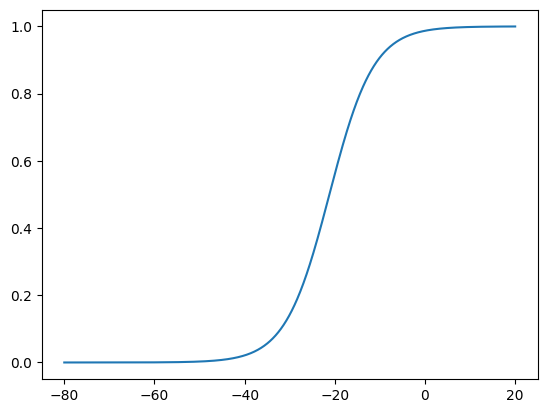

In [7]:
vtha = -21.2
qa = 4.9
v = np.linspace(-80,20,1000)
mInf = 1/(1 + np.exp(-((v) - vtha)/qa))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(v,mInf)

Example of current injection in single compartment cell with Mainen delayed rectifier potassium current. Note units are different for kv and nav11. Kv uses pS/µm2 and Nav1.1 uses S/cm2 (1 S/cm^2 = 10,000 pS/µm2).

In [8]:
soma = h.Section(name='soma')
soma.diam = 25
soma.L = 25
soma.nseg = 1

# Biophysics
soma.cm = 1
soma.insert('pas')
soma.insert('extracellular')
soma.g_pas = 5e-4
soma.e_pas = -60
soma.insert('nav11')
soma.gbar_nav11 = 0.2

soma.insert('kv')
soma.gbar_kv = 150
soma.ena = 50
soma.ek = -80


ic = h.IClamp(soma(0.5))
ic.delay = 50
ic.dur = 200
ic.amp = 0.1

h.v_init = -61 # mV - initial voltage of the model system 
h.dt = 0.005  # ms - time step
h.celsius = 21 # degrees celsius - temperature of simulation, set to room temperature
h.tstop = 250

sTau_vec = h.Vector().record(soma(0.5)._ref_sTau_nav11)
hTau_vec = h.Vector().record(soma(0.5)._ref_hTau_nav11)


In [9]:
h.celsius = 21
ic.amp = 0.4
h.run()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=t,y=V,name='Vm',line=dict(color='rgb(0,0,0)')),secondary_y = False)

fig.add_trace(go.Scatter(x=t,y=m_vec,name='m'),secondary_y = True)
fig.add_trace(go.Scatter(x=t,y=h_vec,name='h'),secondary_y = True)
fig.add_trace(go.Scatter(x=t,y=s_vec,name='s'),secondary_y = True)
fig.add_trace(go.Scatter(x=t,y=sTau_vec/sTau_vec.max(),name='sTau'),secondary_y = True)
# fig.add_trace(go.Scatter(x=t,y=hTau_vec/hTau_vec.max(),name='hTau'),secondary_y = True)
fig.update_layout(yaxis = dict(range=[-80,50]))


Example code to insert the ichanWT2005.mod mechanism that includes their implementation of Nav1.1, with a leak and delayed rectifier (commented, in case you want to use it, replace the code above inserting the nav11, kv, and pas mechanisms with this one)

In [ ]:
# soma.insert('ichanWT2005')
# soma.enat = 50
# soma.ekf = -80
# soma.gnatbar_ichanWT2005 = 0.2
# soma.gkfbar_ichanWT2005  = 0.06
# soma.gl_ichanWT2005 = 0.0005
# soma.el_ichanWT2005 = -60